In [13]:
import numpy as np
import matplotlib.pyplot as plt
import ibeaconsHelper
import trilateration
import CoreLocation


beacon_locations = {1: (171, 0), 2: (0, 108), 3: (0, 216), 4: (0, 0), 5: (279, 101), 6: (108, 251), 7:(121, 144), 8: (279, 179), 9: (273, 0)}
client_locations = {"cattalyya": (160, 109), "ray": (236, 88)}
# ray started at 12:45 am

In [14]:
beacon_locations_3D = {}
for minor, location in beacon_locations.items():
    x, y = location
    beacon_locations_3D[minor] = np.array([x, y, 0])

In [15]:
def rssi_to_distance(rssi, A, n, conversion):
    """ need to find the params A, n that actually match our beacons """
    exponent = 1. * (A - rssi) / (10 * n)
    distance_m = pow(10, exponent)
    return distance_m * conversion

In [16]:
import json

#ray 1525668401385.json
with open('indoor-loc/Server/collected_data/ibeacons/05_06_2018/1525666779192.json', 'r') as f:
    data = json.load(f)

In [17]:
data_by_timestamp = ibeaconsHelper.get_data_by_timestamp(data)

In [18]:
data_by_timestamp

{1525666730.262392: [iBeacon(1)@1525666730.26: rssi=-86, prox=3, accu=16.681005372,
  iBeacon(5)@1525666730.26: rssi=-90, prox=3, accu=27.8255940221,
  iBeacon(6)@1525666730.26: rssi=-92, prox=3, accu=35.938136638,
  iBeacon(2)@1525666730.26: rssi=-92, prox=3, accu=35.938136638,
  iBeacon(8)@1525666730.26: rssi=-93, prox=3, accu=40.8423865267],
 1525666731.260067: [iBeacon(1)@1525666731.26: rssi=-86, prox=3, accu=16.6810054382,
  iBeacon(5)@1525666731.26: rssi=-86, prox=3, accu=23.6486191265,
  iBeacon(2)@1525666731.26: rssi=-90, prox=3, accu=33.7934137022,
  iBeacon(6)@1525666731.26: rssi=-92, prox=3, accu=35.9381369638,
  iBeacon(8)@1525666731.26: rssi=-94, prox=3, accu=41.830319037,
  iBeacon(3)@1525666731.26: rssi=-94, prox=3, accu=46.4158883361],
 1525666732.260857: [iBeacon(1)@1525666732.26: rssi=-85, prox=3, accu=16.0709421594,
  iBeacon(5)@1525666732.26: rssi=-86, prox=3, accu=21.7104099465,
  iBeacon(8)@1525666732.26: rssi=-91, prox=3, accu=39.6871720292,
  iBeacon(9)@15256667

In [19]:
def get_rssi_values(data_by_timestamp, timestamp):
    rssi_values = {}
    for ibeacon_data in data_by_timestamp[timestamp]:
        minor = ibeacon_data.minor
        rssi = ibeacon_data.rssi
        rssi_values[minor] = rssi
    return rssi_values

In [20]:
def get_beacon_distances_from_rssi(rssi_values, A, n, conversion):
    beacon_distances = {}
    for minor, rssi in rssi_values.items():
        beacon_distances[minor] = rssi_to_distance(rssi, A, n, conversion)
    return beacon_distances

### Average prediction over 1 minute

In [21]:
sumX = 0
sumY = 0
timestamp_len = float(len(data_by_timestamp.keys()))
print("Time Length: ", timestamp_len)
for t in data_by_timestamp.keys():
    currPredPos, beacon_points = predict_at_timestamp(data_by_timestamp, beacon_locations, t)
    sumX += currPredPos['x']
    sumY += currPredPos['y']

predictedPos = {'x': sumX/timestamp_len, 'y': sumY/timestamp_len, 'z': 0.0, 'sigPower': None}

('Time Length: ', 49.0)


NameError: name 'predict_at_timestamp' is not defined

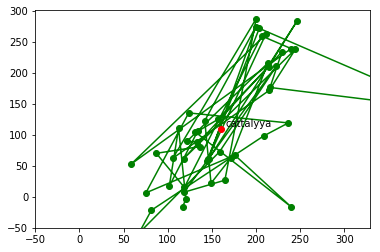

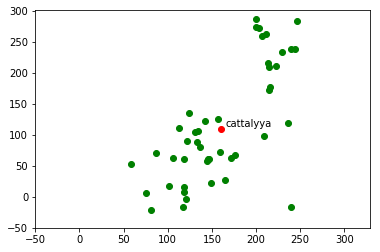

In [35]:
timestamp = 1525668397.2775578 # ray
# timestamp = 1525666731.260067 # cattalyya
conversion = 39.97 # meters to inches
A = -77
n = 2

subject_name = "cattalyya"
predicted_locations = CoreLocation.Locations(subject=subject_name)
xs, ys = zip(*beacon_locations.values())
margin = 50
axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
for timestamp in data_by_timestamp.keys():
    rssi_values = get_rssi_values(data_by_timestamp, timestamp)
    beacon_distances = get_beacon_distances_from_rssi(rssi_values, A, n, conversion)
    predicted_loc = trilateration.trilaterate(beacon_locations, beacon_distances, L2=True)
    # TODO: check why None result from trilateration
    if predicted_loc is not None:
        predicted_locations.add_np_point(predicted_loc, timestamp)
    
subject_point = CoreLocation.Point2D.numpy_to_point(client_locations[subject_name], None)
predicted_locations.visualize(subject_point, ax_limits=axis_limits)
predicted_locations.plot(subject_point, ax_limits=axis_limits)

Should we filter out data if rssi are too low? It's no longer reliable after it's below some threshold.

# Results

In [ ]:
def plot_prediction(beacon_locations, beacon_distances, predicted_location, client_names):
    margin = 50
    xs, ys = zip(*beacon_locations.values())
    axis_limits = [min(xs) - margin, max(xs) + margin, min(ys) - margin, max(ys) + margin]
    fig, ax = plt.subplots()
    
    # assume all beacons in beacon_distances are also in beacon_locations
    for minor in beacon_distances:
        x, y = beacon_locations[minor][:2]
        distance = beacon_distances[minor]
        circle = plt.Circle((x, y), distance, fill=False)
        ax.add_artist(circle)
        ax.plot(x, y, 'bo')
        ax.annotate(minor, (x, y), xytext=(x + 5, y + 5))

    for client_name in client_names:
        x, y = client_locations[client_name]
        ax.plot(x, y, 'go')
        ax.annotate(client_name, (x, y), xytext=(x + 5, y + 5))

    # prediction
    predicted_x, predicted_y = predicted_location[:2]
    ax.plot(predicted_x, predicted_y, 'ro')
    ax.annotate("prediction", (predicted_x, predicted_y), xytext=(predicted_x + 5, predicted_y + 5))
    plt.axis(axis_limits)
    ax.axis('equal')
    plt.title("A: %.2f, n: %.2f" % (A, n))
    plt.show()

In [ ]:
plot_prediction(beacon_locations, beacon_distances, predicted_locations.points[10].coord, ["ray"])

In [ ]:
print rssi_values